In [1]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from openparticle import *
import numpy as np
import cirq
from src.lobe.system import System
from src.lobe.lobe_circuit import lobe_circuit
from src.lobe.block_encoding import add_lobe_oracle
from cirq.contrib.svg import SVGCircuit
from src.lobe.usp import add_naive_usp
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.rescale import rescale_terms, get_numbers_of_bosonic_operators_in_terms, get_number_of_active_bosonic_modes
from src.lobe._utils import get_basis_of_full_system
import matplotlib.pyplot as plt

/Users/carterm.gustin/anaconda3/envs/phd/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
def Hamiltonian(I, g: int = 1):
    H = ParticleOperator({})

    for i in range(I):
        H += ParticleOperator('b' + str(i) + '^ ' + 'b' + str(i)) #free fermion
        H += ParticleOperator('d' + str(i) + '^ ' + 'd' + str(i)) #free antiferm
        H += ParticleOperator('a' + str(i) + '^ ' + 'a' + str(i)) #free bose
        for j in range(I):
            for k in range(I):
                production_str = 'b' + str(i) + "^ " + 'd' + str(j) + "^ " + 'a' + str(k)
                annihilation_str = 'b' + str(i) + ' d' + str(j) + ' a' + str(k) + "^"
                H += g * ParticleOperator(production_str)
                H += g * ParticleOperator(annihilation_str)

    return H

In [3]:
ham = Hamiltonian(2)

In [39]:
def generate_pair_circuit(I, Omega, usp_or_asp, return_type: str = 'gates'):
    NUMERICS = {
        "left_elbows": 0,
        "right_elbows": 0,
        "rotations": 0,
        "ancillae_tracker": [0],
        "angles": [],
    }

    operator =  Hamiltonian(I)
    # operator = ParticleOperator('b0^ d0 a0^ a0^') + 2*ParticleOperator('d0^ a0^ a0') + 3*ParticleOperator('b0^ d0^ d0')
    terms = operator.to_list()

    rescaled_terms, scaling_factor = rescale_terms(terms, Omega)

    coefficients = [term.coeff for term in rescaled_terms]
    norm = sum(np.abs(coefficients))
    target_state = get_target_state(coefficients)

    number_of_modes = max([term.max_mode() for term in terms]) + 1

    rescaled_terms, scaling_factor = rescale_terms(terms, Omega)

    number_of_ancillae = (
        1000  # Some arbitrary large number with most ancilla disregarded
    )
    number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
    number_of_rotation_qubits = max(get_number_of_active_bosonic_modes(terms)) + 1

    block_encoding_scaling_factor = (1 << number_of_index_qubits) * scaling_factor
    
    # Declare Qubits
    circuit = cirq.Circuit()
    validation = cirq.LineQubit(0)
    clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
    rotation_qubits = [
        cirq.LineQubit(i + 1 + number_of_ancillae)
        for i in range(number_of_rotation_qubits)
    ]
    index_register = [
        cirq.LineQubit(i + 1 + number_of_ancillae + number_of_rotation_qubits)
        for i in range(number_of_index_qubits)
    ]
    system = System(
        number_of_modes=number_of_modes,
        maximum_occupation_number=Omega,
        number_of_used_qubits=1
        + number_of_ancillae
        + number_of_rotation_qubits
        + number_of_index_qubits,
        has_fermions=operator.has_fermions,
        has_antifermions=operator.has_antifermions,
        has_bosons=operator.has_bosons,
    )
    circuit.append(cirq.I.on_each(*system.fermionic_register))
    circuit.append(cirq.I.on_each(*system.antifermionic_register))
    for bosonic_reg in system.bosonic_system:
        circuit.append(cirq.I.on_each(*bosonic_reg))
    
    # Generate full Block-Encoding circuit
    circuit.append(cirq.X.on(validation))
    if usp_or_asp == 'usp':
        circuit += add_naive_usp(index_register)
        perform_coefficient_oracle = True
    elif usp_or_asp == "asp":
        circuit += add_prepare_circuit(index_register, target_state=target_state, numerics=NUMERICS)
        perform_coefficient_oracle = False
    circuit += add_lobe_oracle(
        rescaled_terms,
        validation,
        index_register,
        system,
        rotation_qubits,
        clean_ancillae,
        perform_coefficient_oracle=perform_coefficient_oracle,
        decompose=True,
        numerics=NUMERICS,
    )
    if usp_or_asp == 'usp':
        circuit += add_naive_usp(index_register)
    elif usp_or_asp == 'asp':
        circuit += add_prepare_circuit(index_register, target_state=target_state, numerics=NUMERICS)
    # print(circuit)
    if return_type == 'nq':
        return (len(circuit.all_qubits()))
    else:
        return NUMERICS['left_elbows'], NUMERICS['right_elbows'], NUMERICS['rotations']

### Fix $\Omega$, plot $\text{Gate ct. vs.} I$ 

In [37]:
plt.rcParams["font.family"] = "Times New Roman"

In [40]:
fix_Omega = 3

I = np.arange(1, 10, 1)
n_terms = []
I_USP_lelbs = []
I_USP_relbs = []
I_USP_arots = []

I_ASP_lelbs = []
I_ASP_relbs = []
I_ASP_arots = []

for i in I:
    n_terms.append(len(Hamiltonian(i)))
    I_USP_l, I_USP_r, I_USP_ar = generate_pair_circuit(int(i), fix_Omega, 'usp')
    I_USP_lelbs.append(I_USP_l)
    I_USP_relbs.append(I_USP_r)
    I_USP_arots.append(I_USP_ar)
    
    I_ASP_l, I_ASP_r, I_ASP_ar = generate_pair_circuit(int(i), fix_Omega, 'asp')
    I_ASP_lelbs.append(I_ASP_l)
    I_ASP_relbs.append(I_ASP_r)
    I_ASP_arots.append(I_ASP_ar)


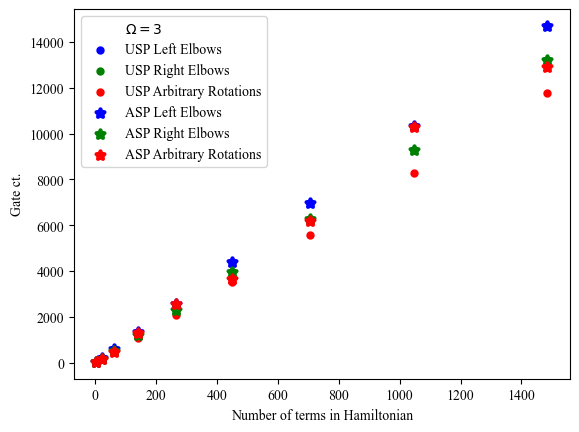

In [62]:

plt.plot([], [], label = f'$\\Omega = {fix_Omega}$', color = 'white')
# plt.scatter(I, np.array(USP_lelbs), color='blue', linewidth = 3, 
#         marker='.', label = "USP Left Elbows")
# plt.scatter(I, np.array(USP_relbs), color='green', linewidth = 3, 
#         marker='.', label = 'USP Right Elbows')
# plt.scatter(I, np.array(USP_arots), color='red', linewidth = 3, 
#         marker='.', label = 'USP Arbitrary Rotations')

# plt.scatter(I, np.array(ASP_lelbs), color='blue', linewidth = 3, 
#         label = "ASP Left Elbows", marker = '*')
# plt.scatter(I, np.array(ASP_relbs), color='green', linewidth = 3, 
#         label = 'ASP Right Elbows', marker = '*')
# plt.scatter(I, np.array(ASP_arots), color='red', linewidth = 3, 
#         label = 'ASP Arbitrary Rotations', marker = '*')

plt.scatter(n_terms, np.array(I_USP_lelbs), color='blue', linewidth = 3, 
        marker='.', label = "USP Left Elbows", alpha = 1)
plt.scatter(n_terms, np.array(I_USP_relbs), color='green', linewidth = 3, 
        marker='.', label = 'USP Right Elbows', alpha = 1)
plt.scatter(n_terms, np.array(I_USP_arots), color='red', linewidth = 3, 
        marker='.', label = 'USP Arbitrary Rotations', alpha = 1)

plt.scatter(n_terms, np.array(I_ASP_lelbs), color='blue', linewidth = 3, 
        label = "ASP Left Elbows", marker = '*', alpha =1)
plt.scatter(n_terms, np.array(I_ASP_relbs), color='green', linewidth = 3, 
        label = 'ASP Right Elbows', marker = '*', alpha =1)
plt.scatter(n_terms, np.array(I_ASP_arots), color='red', linewidth = 3, 
        label = 'ASP Arbitrary Rotations', marker = '*', alpha =1)
plt.ylabel("Gate ct.")
# plt.xlabel("I")
plt.xlabel("Number of terms in Hamiltonian")
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
# plt.title(r"$H = \sum_n^{I} b_n^\dagger b_n + \sum_n^{I} d_n^\dagger d_n + \sum_n^{I} a_n^\dagger a_n + g\sum_{i,j,k}^{I} \left(b_i^\dagger d_j^\dagger a_k + b_i d_j a_k^\dagger \right)$")
plt.show()

In [48]:
fix_I = 2

Omega = np.array([2**n - 1 for n in range(1,11)])
OMEGA_USP_lelbs = []
OMEGA_USP_relbs = []
OMEGA_USP_arots = []

OMEGA_ASP_lelbs = []
OMEGA_ASP_relbs = []
OMEGA_ASP_arots = []

for omega in Omega:
    OMEGA_USP_l, OMEGA_USP_r, OMEGA_USP_ar = generate_pair_circuit(fix_I, omega, 'usp')
    OMEGA_USP_lelbs.append(OMEGA_USP_l)
    OMEGA_USP_relbs.append(OMEGA_USP_r)
    OMEGA_USP_arots.append(OMEGA_USP_ar)
    
    OMEGA_ASP_l, OMEGA_ASP_r, OMEGA_ASP_ar = generate_pair_circuit(fix_I, omega, 'asp')
    OMEGA_ASP_lelbs.append(OMEGA_ASP_l)
    OMEGA_ASP_relbs.append(OMEGA_ASP_r)
    OMEGA_ASP_arots.append(OMEGA_ASP_ar)


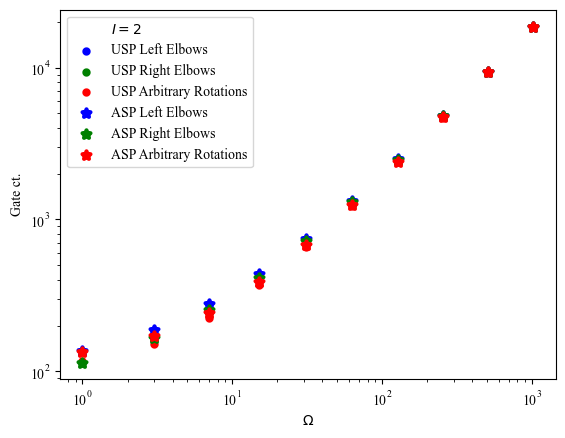

In [61]:

plt.plot([], [], label = f'$I = {fix_I}$', color = 'white')
plt.scatter(Omega, np.array(OMEGA_USP_lelbs), color='blue', linewidth = 3, 
        marker='.', label = "USP Left Elbows")
plt.scatter(Omega, np.array(OMEGA_USP_relbs), color='green', linewidth = 3, 
        marker='.', label = 'USP Right Elbows')
plt.scatter(Omega, np.array(OMEGA_USP_arots), color='red', linewidth = 3, 
        marker='.', label = 'USP Arbitrary Rotations')

plt.scatter(Omega, np.array(OMEGA_ASP_lelbs), color='blue', linewidth = 3, 
        label = "ASP Left Elbows", marker = '*')
plt.scatter(Omega, np.array(OMEGA_ASP_relbs), color='green', linewidth = 3, 
        label = 'ASP Right Elbows', marker = '*')
plt.scatter(Omega, np.array(OMEGA_ASP_arots), color='red', linewidth = 3, 
        label = 'ASP Arbitrary Rotations', marker = '*')
plt.ylabel("Gate ct.")
plt.xlabel(f"$\\Omega$")
plt.legend()
plt.yscale('log')
plt.xscale('log')
# plt.title(r"$H = \sum_n^{I} b_n^\dagger b_n + \sum_n^{I} d_n^\dagger d_n + \sum_n^{I} a_n^\dagger a_n + g\sum_{i,j,k}^{I} \left(b_i^\dagger d_j^\dagger a_k + b_i d_j a_k^\dagger \right)$")
plt.show()

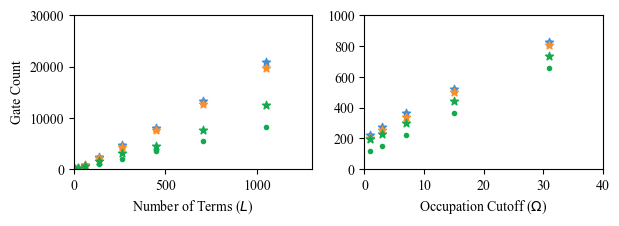

In [170]:
BLUE = "#3D8EDD"
ORANGE = "#FD8F29"
GREEN = "#14A94E"
RED_ORANGE = "#FC4E14"
RED = "#FC2855"
PURPLE = "#DF6DF7"
PINK = "#FD57CC"

# 16 is the width in cm
# 6 is the height in cm
fig, axes = plt.subplots(1, 2, figsize=(16 / 2.54, 6 / 2.54))

axes[0].set_ylabel("Gate Count")
axes[0].scatter(n_terms, np.array(I_USP_lelbs), label="", color=BLUE, marker=".")
axes[0].scatter(n_terms, np.array(I_USP_relbs), label="", color=ORANGE, marker=".")
axes[0].scatter(n_terms, np.array(I_USP_arots), label="", color=GREEN, marker=".")
axes[0].scatter(n_terms, np.array(I_ASP_lelbs), label="", color=BLUE, marker="*")
axes[0].scatter(n_terms, np.array(I_ASP_relbs), label="", color=ORANGE, marker="*")
axes[0].scatter(n_terms, np.array(I_ASP_arots), label="", color=GREEN, marker="*")
axes[0].plot([], [], color = 'white', label = f'$\\Omega = 3$')
axes[0].set_ylim(0, 3e4)
axes[0].set_xlim(0, 1300)
# axes[0].legend(loc = 'upper left')
# axes[0].set_yscale("log")
axes[0].set_xlabel("Number of Terms ($L$)")

axes[1].scatter(Omega, np.array(OMEGA_USP_lelbs), label="", color=BLUE, marker=".")
axes[1].scatter(Omega, np.array(OMEGA_USP_relbs), label="", color=ORANGE, marker=".")
axes[1].scatter(Omega, np.array(OMEGA_USP_arots), label="", color=GREEN, marker=".")
axes[1].scatter(Omega, np.array(OMEGA_ASP_lelbs), label="", color=BLUE, marker="*")
axes[1].scatter(Omega, np.array(OMEGA_ASP_relbs), label="", color=ORANGE, marker="*")
axes[1].scatter(Omega, np.array(OMEGA_ASP_arots), label="", color=GREEN, marker="*")
axes[1].set_ylim(0, 1000)
axes[1].set_xlim(0, 40)
axes[1].set_xlabel("Occupation Cutoff ($\\Omega$)")

plt.tight_layout()
plt.savefig("myfig.pdf", dpi=600) 

### $N_{\text{Qubits}}$ vs. I/$\Omega$

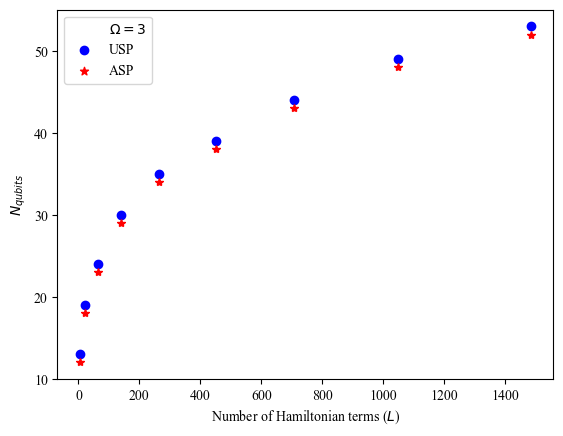

In [51]:
fix_Omega = 3

for i in range(1, 10):
    plt.plot(len(Hamiltonian(i)), generate_pair_circuit(i, fix_Omega, 'usp', 'nq'), marker = 'o', color = 'blue')
    plt.plot(len(Hamiltonian(i)), generate_pair_circuit(i, fix_Omega, 'asp', 'nq'), marker = '*', color = 'red')
plt.ylabel(r"$N_{qubits}$")
plt.xlabel("Number of Hamiltonian terms ($L$)")
plt.plot([], [], color = 'white',label = f'$\\Omega = 3$')
plt.scatter([], [], color = 'blue',label = f'USP')
plt.scatter([], [], color = 'red',label = f'ASP', marker = '*')
plt.legend()
plt.show()

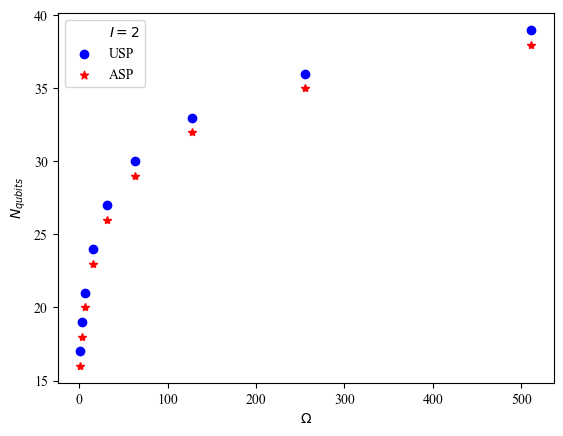

In [57]:
fix_I = 2

for omega in [2**n - 1 for n in range(1, 10)]:
    plt.plot(omega, generate_pair_circuit(fix_I, omega, 'usp', 'nq'), marker = 'o', color = 'blue')
    plt.plot(omega, generate_pair_circuit(fix_I, omega, 'asp', 'nq'), marker = '*', color = 'red')
plt.ylabel(r"$N_{qubits}$")
plt.xlabel(f"$\\Omega$")
plt.plot([], [], color = 'white',label = f'$I = 2$')
plt.scatter([], [], color = 'blue',label = f'USP')
plt.scatter([], [], color = 'red',label = f'ASP', marker = '*')
plt.legend()
plt.show()